In [1]:
import sys
sys.path.append("C://Users//User//PycharmProjects//Musgrave_scripts//BenRich//common_funcs")
import cohpfuncs as cfunc
import jdftxfuncs as jfunc
data_dir = "E://perl//pscratch//beri9208//pot_scan//PtPyr//"
import numpy as np
import matplotlib.pyplot as plt
save_dir = "C://Users//User//Desktop//pcoop_plots//"
import time
import os
import matplotlib.colors as mcolors
from numba import jit

In [8]:
def app_dir(surf_idx, mu_idx):
    """
    :param surf_idx: 0 --> 2n-cis, 1 --> 2n-trans
    :param mu_idx: 0 --> No_bias, -1 --> dneg/1, 1 --> 2pos/1
    :return:
    """
    out_str = ""
    if surf_idx:
        out_str += "2n-trans//"
    else:
        out_str += "2n-cis//"
    if mu_idx == 0:
        out_str += "No_bias//"
    else:
        if mu_idx > 0:
            out_str += "dpos//"
        else:
            out_str += "dneg//"
        out_str += str(int(abs(mu_idx))) + "//"
    return data_dir + out_str

surf_labels = ["cis", "trans"]
bias_labels = ["-0.3V", "0.0V", "0.3V", "0.6", "0.9V", "-1.5V", "-1.2V","-0.9V", "-0.6V"]

def gen_dirname(lookat1, lookat2, surf_idx, save_dir):
    slabel = surf_labels[surf_idx]
    out_str = save_dir + slabel
    out_str += lookat1.split(' #')[0]
    out_str += lookat1.split(' #')[1]
    out_str += '-'
    out_str += lookat2.split(' #')[0]
    out_str += lookat2.split(' #')[1]
    out_str += '//'
    return out_str

def lb_idx(Emin, dE, sample):
    a = sample-Emin
    b = a/dE
    c = int(np.floor(b))
    return c, abs(b-c)

def lsstr(atom_label):
    saveable_string = ""
    use = atom_label.split(" #")
    for u in use:
        saveable_string += u
    return saveable_string


def system_atomwise_pcoop_matrix_all(surf_idx, bias_idx):
    proj, nStates, nBands, nProj, nOrbsPerAtom, wk, k_points, E = cfunc.parse_data(
        app_dir(surf_idx, bias_idx) + "bandProjections",
        app_dir(surf_idx, bias_idx) + "Gvectors",
        app_dir(surf_idx, bias_idx) + "eigenvals")
    orbs_dict = cfunc.orbs_idx_dict(app_dir(surf_idx, bias_idx) + "out", nOrbsPerAtom)
    S, R, mu = jfunc.get_vars(app_dir(surf_idx, bias_idx) + "out")
    nk, nj = np.shape(E)
    orbital_labels = []
    maxint = max(orbs_dict["Pt #1"]) + 2
    for i in range(maxint):
        orbital_labels.append("n/a")
    pt_orbs = ["6s", "6px", "6py", "6pz", "7px", "7py", "7pz", "5dxy", "5dyz", "5dxz", "5dx2y2", "5dz2"]
    ticker = 0
    for atom in orbs_dict.keys():
        if ("C " in atom) or ("N " in atom):
            orbital_labels[ticker] = "2s"
            orbital_labels[ticker + 1] = "2px"
            orbital_labels[ticker + 2] = "2py"
            orbital_labels[ticker + 3] = "2pz"
            ticker += 4
        else:
            for orb in pt_orbs:
                orbital_labels[ticker] = orb
                ticker += 1
    orbs_sample = np.ones([len(orbs_dict.keys()), 12]) * (-1)
    for i, keyi in enumerate(orbs_dict.keys()):
        for j, idxj in enumerate(orbs_dict[keyi]):
            orbs_sample[i][j] = orbs_dict[keyi][j]

    @jit(nopython=True)
    def get_overlap_matrix(proj, wk, orbs_sample, nk, nj, out):
        for i in range(len(orbs_sample)):
            for j in range(len(orbs_sample)):
                for u1 in orbs_sample[i]:
                    if u1 > 0:
                        for v1 in orbs_sample[j]:
                            if v1 > 0:
                                for ik in range(nk):
                                    for ij in range(nj):
                                        t1 = proj[ik][ij][u1]
                                        t2 = proj[ik][ij][v1]
                                        t1_conj = t1.real - t1.imag * 1j
                                        out[i, j] += abs(t1_conj * t2) * abs(wk[ik])
        return out
    ## JIT THIS UP
    ###############
    pcoops_list = get_overlap_matrix(np.array(proj, dtype=np.complex128), np.array(wk), np.array(orbs_sample, dtype=int), nk, nj, np.zeros([len(orbs_sample), len(orbs_sample)], dtype=np.complex128))
    ###############
    """
    pcoops_list: 2d list
    Erange: 1d range
    titles_and_idcs_and_mu: [title, data i/j pair, mu]
    """
    return pcoops_list, mu, orbs_dict.keys()

In [9]:
datum = []
times = []
bidrange = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
for sidx in [0,1]:
    datum.append([])
    for bidx in bidrange:
        start = time.time()
        datum[-1].append(system_atomwise_pcoop_matrix_all(sidx, bidx))
        end = time.time()
        elapsed = end - start
        times.append(elapsed)
        print(str(sidx*len(bidrange) + bidx + 5) + "/18: " + str(elapsed) + " seconds.")
        print('avg: ' + str(np.average(times)))

1/18: 1.2452802658081055 seconds.
avg: 1.2452802658081055
2/18: 1.1902687549591064 seconds.
avg: 1.217774510383606
3/18: 1.1622614860534668 seconds.
avg: 1.1992701689402263
4/18: 1.3152966499328613 seconds.
avg: 1.228276789188385
5/18: 1.186267375946045 seconds.
avg: 1.219874906539917
6/18: 1.1722650527954102 seconds.
avg: 1.2119399309158325
7/18: 1.1632611751556396 seconds.
avg: 1.2049858229500907
8/18: 1.1632640361785889 seconds.
avg: 1.199770599603653
9/18: 1.2732856273651123 seconds.
avg: 1.2079389360215929
10/18: 1.175264835357666 seconds.
avg: 1.2046715259552
11/18: 1.1952693462371826 seconds.
avg: 1.2038167823444714
12/18: 1.1672637462615967 seconds.
avg: 1.2007706960042317
13/18: 1.3232977390289307 seconds.
avg: 1.210195853159978
14/18: 1.2412796020507812 seconds.
avg: 1.2124161209378923
15/18: 1.2772891521453857 seconds.
avg: 1.2167409896850585
16/18: 1.1642615795135498 seconds.
avg: 1.2134610265493393
17/18: 1.184267282485962 seconds.
avg: 1.2117437474867876
18/18: 1.30529403

In [10]:
arr = np.real(datum[0][0][0])
sorted_indices = np.argsort(arr, axis=None)

# Use the sorted indices to extract the sorted values and their corresponding indices
sorted_values = arr.flat[sorted_indices]
sorted_indices = np.unravel_index(sorted_indices, arr.shape)

# Print the sorted values and their indices
for i in range(sorted_values.size):
    print(f"Value: {sorted_values[i]}, Index: {sorted_indices[0][i]}, {sorted_indices[1][i]}")

Value: 29.646281257034538, Index: 46, 0
Value: 29.646281257034673, Index: 0, 46
Value: 29.816439375324716, Index: 16, 0
Value: 29.816439375324777, Index: 0, 16
Value: 29.960153791614342, Index: 47, 0
Value: 29.960153791614403, Index: 0, 47
Value: 30.056983960442352, Index: 18, 0
Value: 30.0569839604424, Index: 0, 18
Value: 30.24567297870944, Index: 0, 38
Value: 30.245672978709493, Index: 38, 0
Value: 30.308149395850393, Index: 0, 27
Value: 30.308149395850506, Index: 27, 0
Value: 30.477802493100523, Index: 0, 5
Value: 30.477802493100523, Index: 5, 0
Value: 30.596663636026758, Index: 0, 25
Value: 30.596663636026957, Index: 25, 0
Value: 30.815614347091465, Index: 0, 3
Value: 30.815614347091515, Index: 3, 0
Value: 30.92337491135718, Index: 40, 0
Value: 30.923374911357268, Index: 0, 40
Value: 31.658022345733215, Index: 11, 0
Value: 31.658022345733222, Index: 0, 11
Value: 32.06568046882043, Index: 0, 6
Value: 32.06568046882063, Index: 6, 0
Value: 32.24483950150542, Index: 0, 7
Value: 32.2448

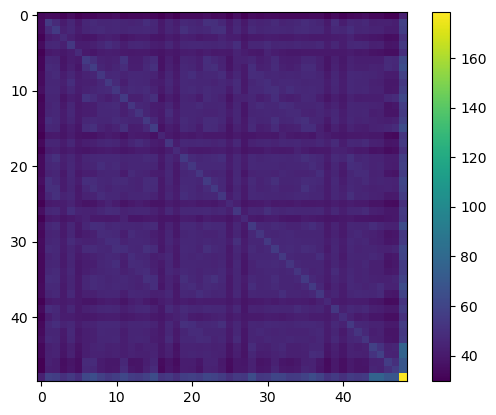

In [17]:
plt.imshow(np.real(datum[0][0][0]))
plt.colorbar()

In [16]:
surf_labels[0]

'cis'

C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


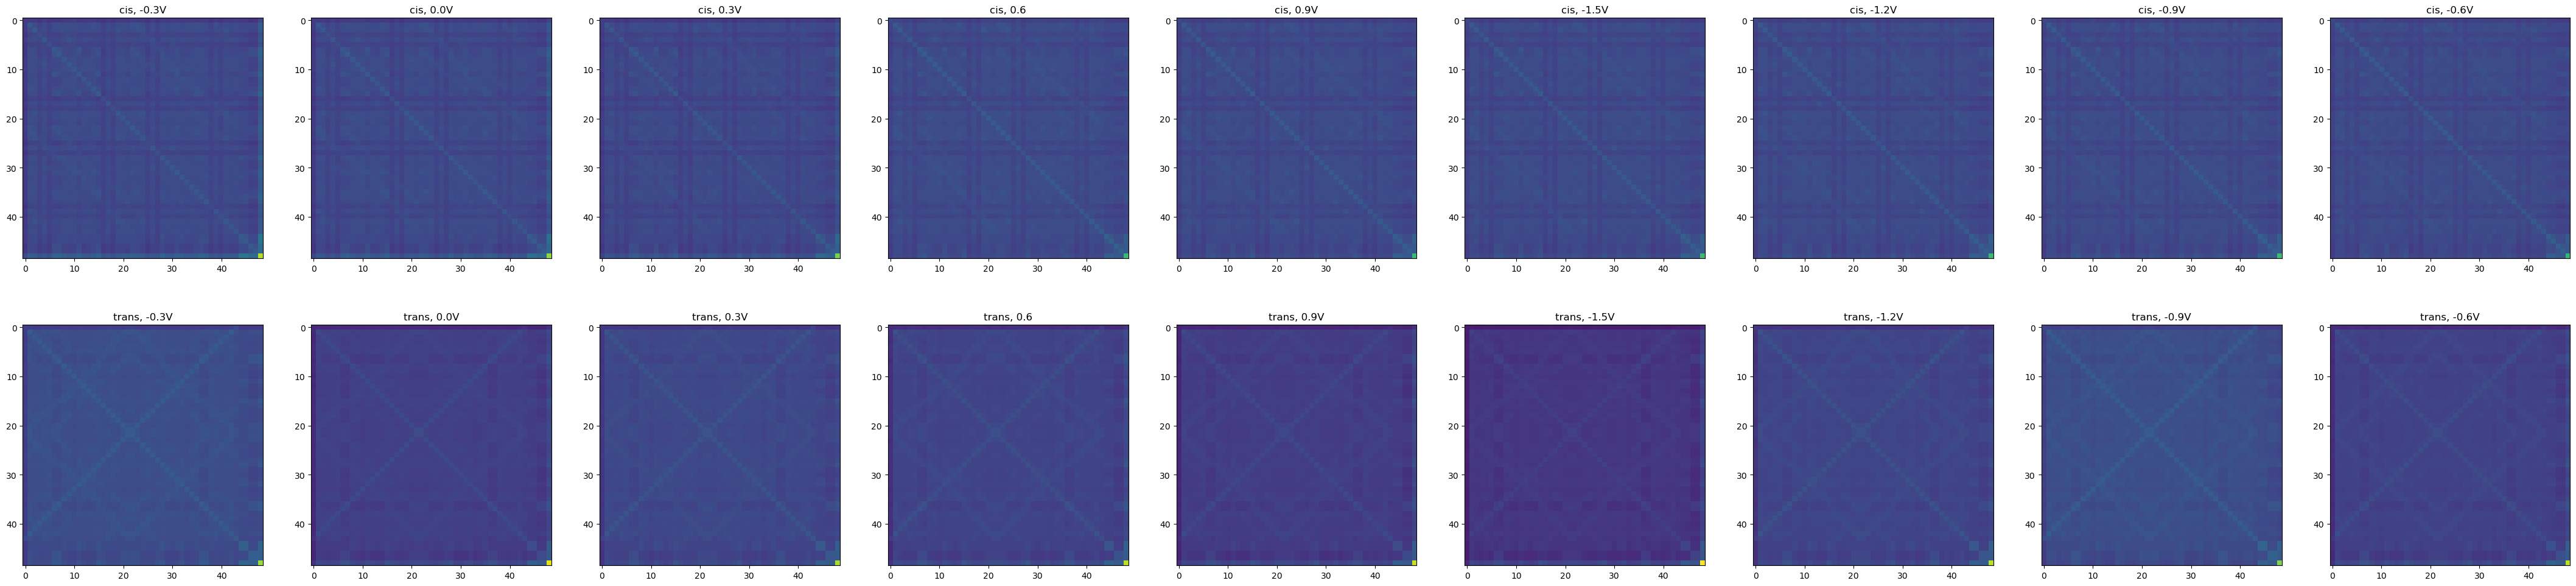

In [15]:

vmin = 0
vmax = 0
dshape = np.shape(datum)
for i in range(dshape[0]):
    for j in range(dshape[1]):
        vmin = min(vmin, np.min(np.real(datum[i][j][0])))
        vmax = max(vmax, np.max(np.real(datum[i][j][0])))
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
fig, axes = plt.subplots(nrows=dshape[0], ncols=dshape[1], figsize=(6*dshape[1], 6*dshape[0]))
for i in range(dshape[0]):
    for j in range(dshape[1]):
        im = axes[i][j].imshow(np.real(datum[i][j][0]), norm=norm)
        axes[i][j].set_title(surf_labels[i] + ", " + bias_labels[j])